# Copulas

In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.sandbox.distributions.multivariate import multivariate_t_rvs
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from copulas.univariate import GaussianKDE

In [2]:
returns_test = pd.read_csv('data/returns_test.csv', index_col=0)
returns_train = pd.read_csv('data/returns_train.csv', index_col=0)
columns = returns_train.columns
returns_train.head()

,brent,crude,gasoline,heating,gas,natural
date,,,,,,
2008-01-02,-0.002453,-0.004417,-0.001007,-0.007773,0.006433,-0.022420
2008-01-03,-0.008299,-0.012805,-0.004679,-0.013093,-0.016270,0.021762
2008-01-04,-0.024796,-0.028802,-0.028853,-0.033538,-0.035440,0.004846
2008-01-07,0.012183,0.013040,0.012435,0.016503,0.027863,0.011169
2008-01-08,-0.012246,-0.006851,-0.015620,-0.008686,0.005958,0.016568


## Student t marginals fitting

In [3]:
t_param = dict()
for col in columns:
    t_param[col] = stats.t.fit(returns_train[col])
pd.DataFrame(t_param, index=['df', 'loc', 'scale']).T

,df,loc,scale
brent,2.742473,-0.000196,0.013818
crude,2.865713,-0.000137,0.015435
gasoline,2.898108,0.000319,0.015214
heating,3.163602,-0.000149,0.013571
gas,2.519143,-0.000115,0.011161
natural,4.420083,-0.001031,0.022375


## Gaussian KDE marginals fitting

In [4]:
kde_marginals = {}
for i in columns:
    X = returns_train[i].values
    kde = GaussianKDE()
    kde.fit(X)
    kde_marginals[i] = kde

## Covariation fitting

In [5]:
cov = returns_train.cov().values
returns_train.cov()

,brent,crude,gasoline,heating,gas,natural
brent,0.000499,0.000480,0.000423,0.000405,0.000271,0.000125
crude,0.000480,0.000616,0.000426,0.000403,0.000272,0.000138
gasoline,0.000423,0.000426,0.000644,0.000366,0.000231,0.000112
heating,0.000405,0.000403,0.000366,0.000425,0.000255,0.000124
gas,0.000271,0.000272,0.000231,0.000255,0.000355,0.000066
natural,0.000125,0.000138,0.000112,0.000124,0.000066,0.000914


## Degree of freedom fitting

In [6]:
df = pd.DataFrame(t_param, index=['df', 'loc', 'scale']).T['df'].mean()
df

3.1015200955565994

## Generation

Generating 10000 observations from the t distribution

In [7]:
t_sample = multivariate_t_rvs([0, 0, 0, 0, 0, 0], cov, df, 10000)

Uniform transformation

In [8]:
unif_sample = []
for i, i_sample in enumerate(t_sample.T):
    unif_sample.append(stats.t.cdf(i_sample, df=df, loc=0, scale=cov[i][i]**(1/2)))
unif_sample = np.array(unif_sample)

### t copula, t marginals

In [9]:
gen_t_copula = {}
for i, col in enumerate(columns):
    df, loc, scale = t_param[col]
    gen_t_copula[col] = stats.t.ppf(unif_sample[i], df, loc, scale)

gen_t_copula = pd.DataFrame(gen_t_copula, columns=columns)
gen_t_copula['type'] = 'generated'
returns_test['type'] = 'real'

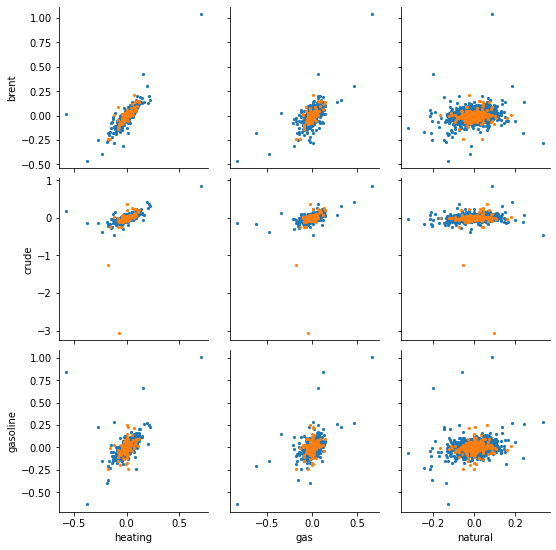

In [10]:
g = sns.pairplot(
    pd.concat([gen_t_copula, returns_test]), 
    hue="type", 
    x_vars=["heating", "gas", 'natural'],
    y_vars=["brent", "crude", 'gasoline'],
    plot_kws=dict(s=10, linewidth=0)
)
g._legend.remove()
plt.show()

### t copula, Gaussian KDE marginals

In [11]:
gen_t_copulaKDE = {}
for i, col in enumerate(columns):
    gen_t_copulaKDE[col] = kde_marginals[col].percent_point(unif_sample[i])

gen_t_copulaKDE = pd.DataFrame(gen_t_copulaKDE, columns=columns)
gen_t_copulaKDE['type'] = 'generated'
returns_test['type'] = 'real'

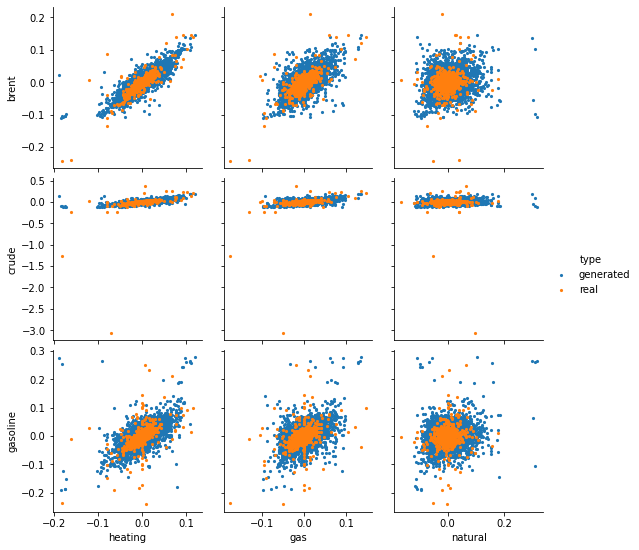

In [13]:
sns.pairplot(
    pd.concat([gen_t_copulaKDE, returns_test]), 
    hue="type", 
    x_vars=["heating", "gas", 'natural'],
    y_vars=["brent", "crude", 'gasoline'],
    plot_kws=dict(s=10, linewidth=0)
)
plt.show()

In [14]:
gen_t_copulaKDE.to_csv('data/gen_t_copulaKDE.csv')
gen_t_copula.to_csv('data/gen_t_copula.csv')